In [ ]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06g_tiling.ipynb"
_nb_title = "Creating image tiles from a larger image"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))

# Creating image tiles from a larger image

In this notebook, we show how to build an input pipeline that tiles a large geospatial image.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Input data

Read the input data

In [13]:
!gsutil cat gs://practical-ml-vision-book-data/images/california_fires.txt

{"fullimg": "gs://practical-ml-vision-book-data/images/california_fire1.jpg", "fires": [[88, 244], [118, 257], [118, 285], [160, 276], [296, 379]]}
{"fullimg": "gs://practical-ml-vision-book-data/images/california_fire2.jpg", "fires": [[84, 255], [90, 250], [118, 261], [119, 288], [152, 501], [160, 281], [296, 383]]}


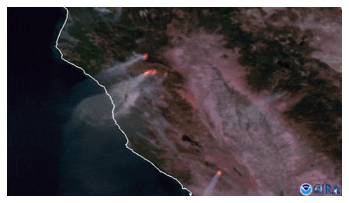

In [14]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import json

def read_jpeg(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

fullimg = read_jpeg('gs://practical-ml-vision-book-data/images/california_fire1.jpg')
plt.imshow(fullimg);
plt.axis('off');

## Tiling the image

(1, 4, 8, 49152)
(4, 8, 128, 128, 3)


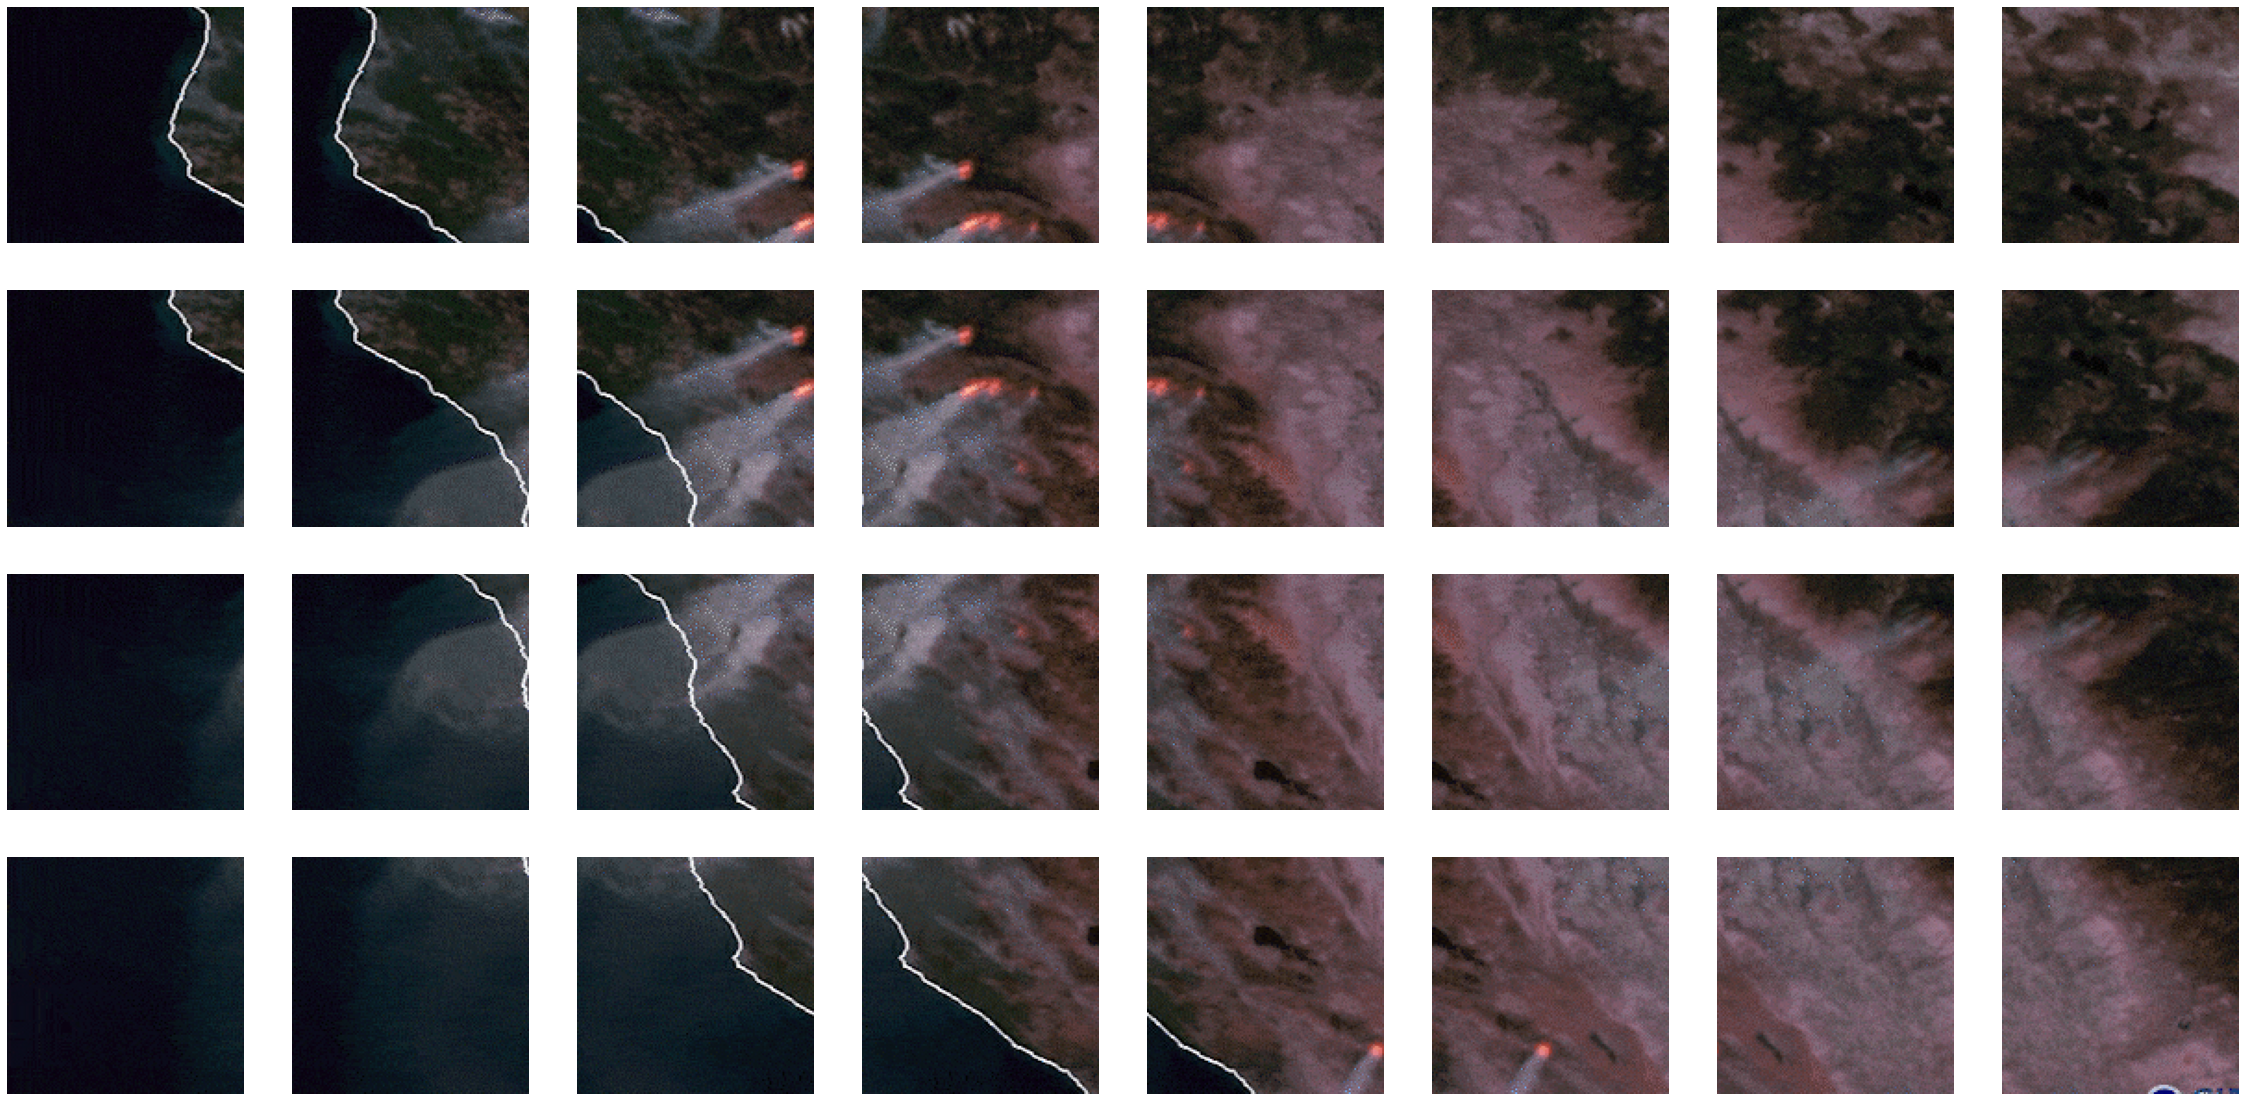

In [ ]:
def tile_image(fullimg, CHANNELS=3, TILE_HT=128, TILE_WD=128):
    # Add a batch dimension: shape (1, height, width, channels)
    images = tf.expand_dims(fullimg, axis=0)

    # Extract overlapping patches from the image:
    # Each patch is of size TILE_HT x TILE_WD (e.g., 128x128),
    # Strides move half the patch size so there is overlap, e.g., stride 64 with patch 128
    # Padding is 'VALID', meaning only patches fully inside the image are extracted
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],      # patch size
        strides=[1, TILE_HT//2, TILE_WD//2, 1], # stride for sliding window
        rates=[1, 1, 1, 1],                  # sampling rate (no dilation here)
        padding='VALID')
    print(tiles.shape)  # Shape is (1, num_patches_y, num_patches_x, patch_flattened)

    # Remove the batch dimension to get (num_patches_y, num_patches_x, patch_flattened)
    tiles = tf.squeeze(tiles, axis=0)

    # Get the number of tile rows and columns
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]

    # Reshape the flat patch vectors into the appropriate tile shape
    # Each tile has shape (TILE_HT, TILE_WD, CHANNELS)
    tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    print(tiles.shape)  # Now (nrows, ncols, TILE_HT, TILE_WD, CHANNELS)

    return tiles

# Tile the full image using the above function
tiles = tile_image(fullimg)

# Get the number of rows and columns of tiles
nrows = tiles.shape[0]
ncols = tiles.shape[1]

# Plot each tile as a subplot in a grid
f, ax = plt.subplots(nrows, ncols, figsize=(40,20))
for rowno in range(nrows):
    for colno in range(ncols):
        img = tiles[rowno][colno]
        # Display the tile
        ax[rowno, colno].imshow(tiles[rowno][colno].numpy())
        ax[rowno, colno].axis('off')

## Getting the label for each tile

We take the fire locations, plot them on the image, tile the image, and then find the maximum pixel within each tile.
If the max pixel is 1.0, then the tile contains a fire.

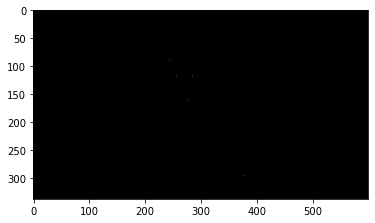

In [16]:
fire_locations = [[88, 244], [118, 257], [118, 285], [160, 276], [296, 379]]
fire_label = np.zeros((338, 600))
for loc in fire_locations:
    fire_label[loc[0]][loc[1]] = 1.0
plt.imshow(fire_label, cmap='gray');

In [ ]:
# This code takes the fire label "mask" (with 1s at the fire pixel coordinates),
# and determines which tiles contain a fire by tiling the mask, then checking each tile for a fire pixel.

# Step 1: Add a singleton channel dimension (from [338, 600] to [338, 600, 1])
labels = tf.expand_dims(fire_label, axis=-1)
print(labels.shape)  # shape is (338, 600, 1)

# Step 2: Tile the label mask image in the same way as the original image,
# but we use a single channel (channel dim=1).
labels = tile_image(labels, 1)  # now (nrows, ncols, TILE_HT, TILE_WD, 1)

# Step 3: For each tile, reduce (i.e., collapse) the height, width, and channel dimensions
# to a single value using max() -- if any pixel in the tile has value 1.0, the max is 1.
labels = tf.reduce_max(labels, axis=[2, 3, 4])
print(labels)  # each [i,j] is 1 if tile [i,j] contains a fire pixel, else 0

(338, 600, 1)
(1, 4, 8, 16384)
(4, 8, 128, 128, 1)
tf.Tensor(
[[0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]], shape=(4, 8), dtype=float64)


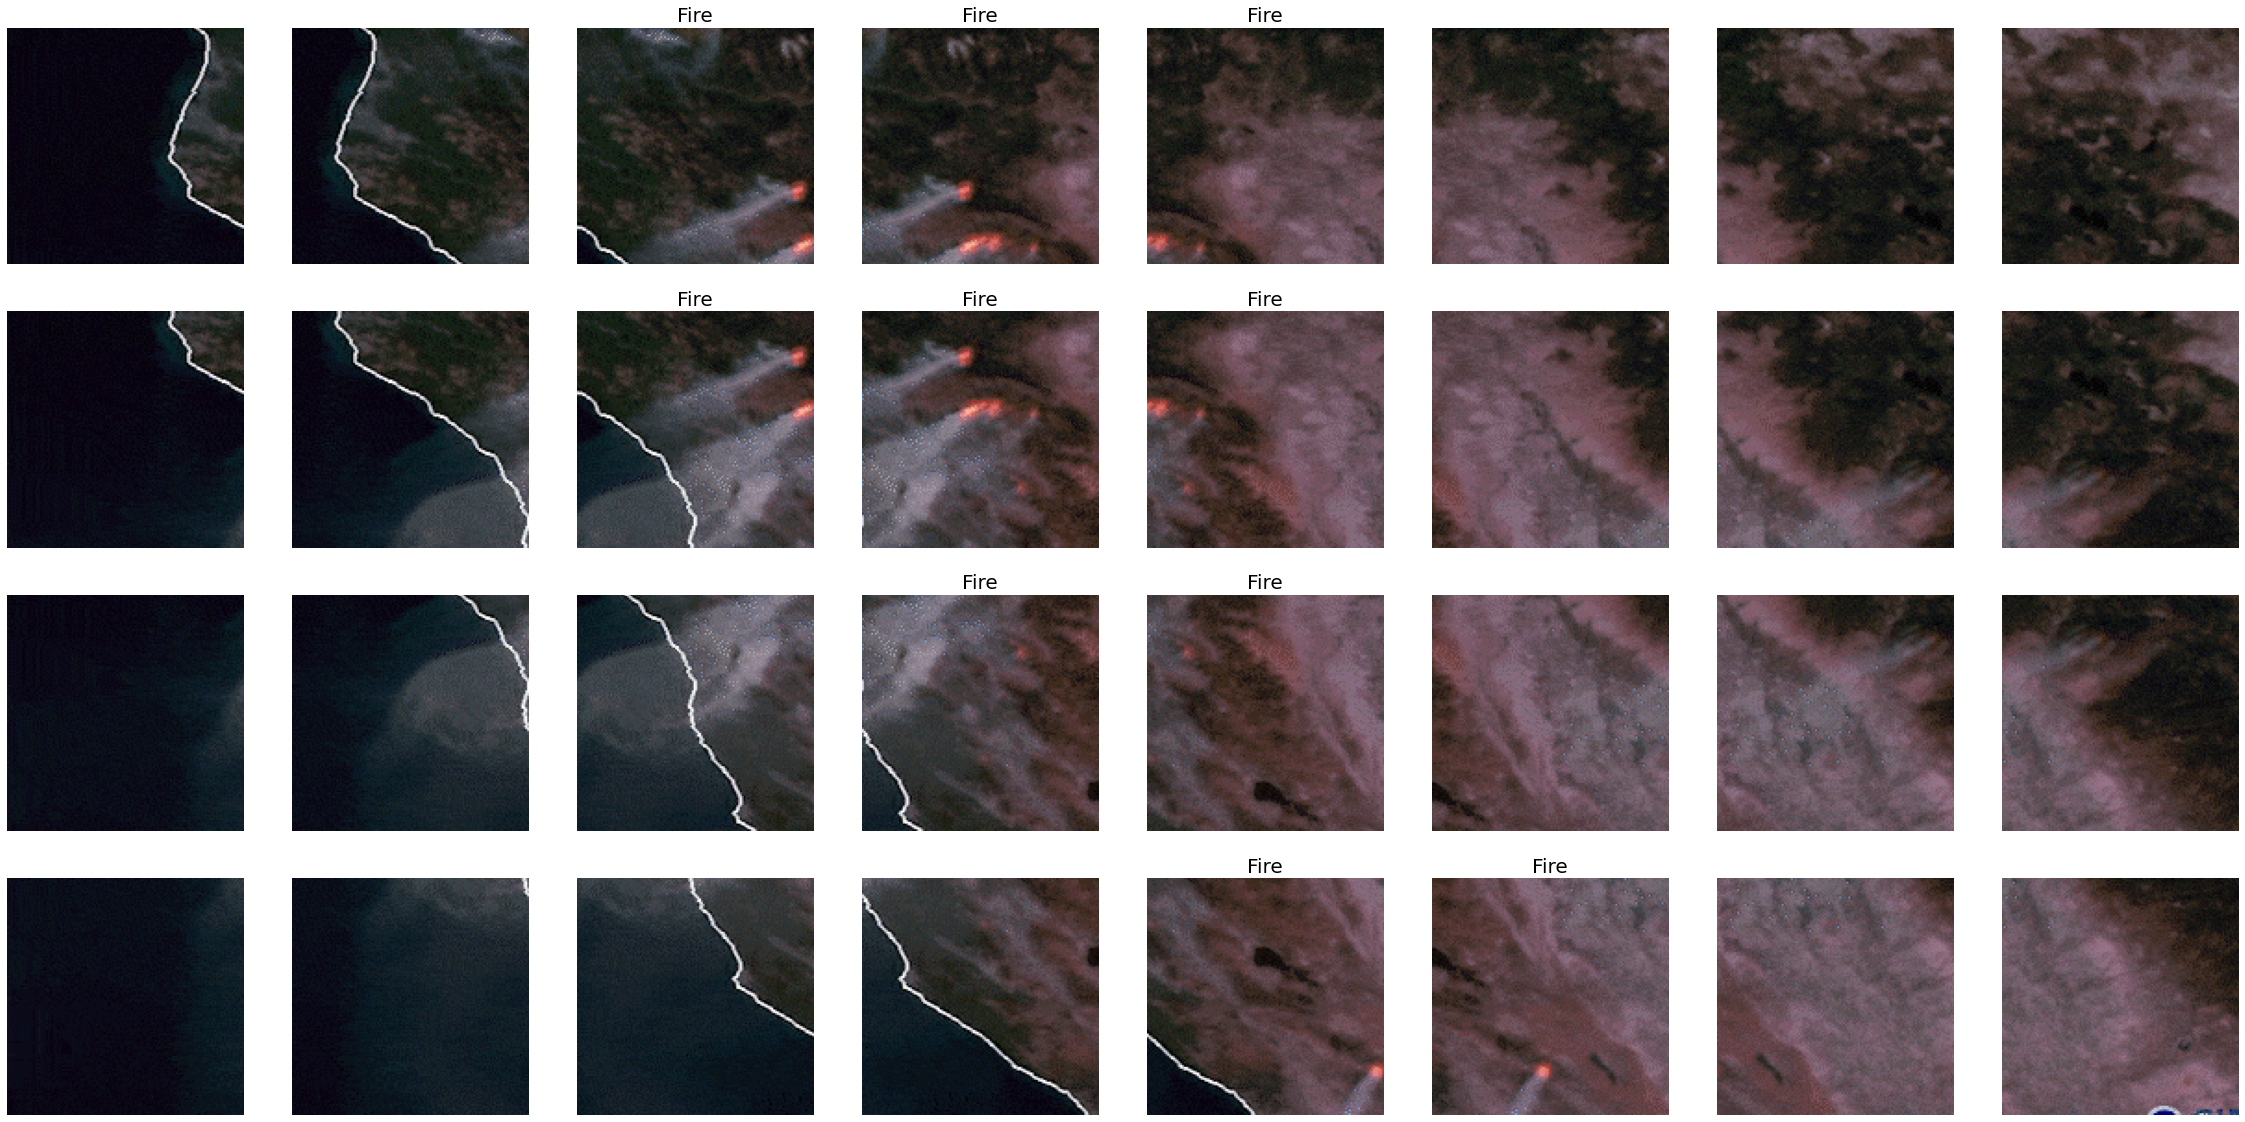

In [18]:
f, ax = plt.subplots(nrows, ncols, figsize=(40,20))
for rowno in range(nrows):
    for colno in range(ncols):
        img = tiles[rowno][colno]
        ax[rowno, colno].imshow( tiles[rowno][colno].numpy() );
        ax[rowno, colno].axis('off')
        if labels[rowno][colno] > 0:
            ax[rowno, colno].set_title('Fire', fontsize=20)

## Read from file

This shows how to create a pipeline starting from a text file
that consists of the full image file and fire_locations

In [ ]:
# The following functions are used to read in full image data and fire location annotations
# from a text file where each line is a JSON object. Each JSON object contains the filename
# of a JPEG image (`fullimg`) and a list of fire locations (`fires`). The process involves:
#   1. Reading the JPEG file into a float32 tensor.
#   2. Creating a label "image" where fire pixels are set to 1.0.
#   3. Returning both data structures for downstream tiling and visualization.

def read_jpeg(filename):
    # Reads the raw bytes from a JPEG file, decodes it as an RGB image,
    # and rescales to float32 in [0,1]
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    print(img.shape)  # Shows the shape, e.g., (338, 600, 3)
    return img

def load_from_line(line):
    # Parses a line from the dataset (which is JSON-encoded),
    # loads the corresponding full image and fire locations.
    # line: tf.string, a JSON-encoded line
    data = json.loads(line.numpy())
    fullimg = read_jpeg(data['fullimg'])  # Load image
    fires = tf.convert_to_tensor(data['fires'], dtype=tf.int32)  # List of fire locations
    return (fullimg, fires)

def create_label_image(fullimg, fire_locations):
    # Creates a label mask from fire location coordinates.
    # The label image has 1.0 at each fire location in the first channel.
    labels = np.zeros_like(fullimg.numpy())
    for loc in fire_locations.numpy():
        labels[loc[0]][loc[1]][0] = 1.0
    return labels

def get_img_fires(line):
    # Combines above logic for TF data pipelines.
    # Given a line, returns the float32 full image, fire locations,
    # and a label mask (same shape as image, only first channel used).
    # py_function is needed because of Python-side string/JSON parsing.
    fullimg, fire_locations = tf.py_function(
        load_from_line, [line], [tf.float32, tf.int32]
    )
    fullimg = tf.reshape(fullimg, [338, 600, 3])
    labels = tf.py_function(create_label_image, [fullimg, fire_locations], [tf.float32])
    labels = tf.reshape(labels, [338, 600, 3])
    return fullimg, fire_locations, labels

In [ ]:
ds = tf.data.TextLineDataset('gs://practical-ml-vision-book-data/images/california_fires.txt').map(get_img_fires)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, (fullimg, fire_locations, labels) in enumerate(ds):
    ax[idx].imshow( fullimg.numpy() );
    ax[idx].set_title( '{}'.format(fire_locations.numpy()) )

In [ ]:
# The code below tiles an image into smaller (128x128) regions, labels each tile as containing fire or not, and displays the tiles.
# Step-by-step explanation:

TILE_HT = 128  # Height of each tile
TILE_WD = 128  # Width of each tile

def tile_image(fullimg, CHANNELS=3):
    """
    Splits the input image into overlapping tiles of size TILE_HT x TILE_WD.
    - fullimg: input image tensor, shape [height, width, channels]
    Returns a tensor of shape [num_tiles, TILE_HT, TILE_WD, channels].
    """
    # Add a batch dimension since extract_patches expects rank-4 tensors
    images = tf.expand_dims(fullimg, axis=0)
    # Use extract_patches to get sliding windows/tiles
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],                 # patch size (tile)
        strides=[1, TILE_HT//2, TILE_WD//2, 1],         # overlap by 50%
        rates=[1, 1, 1, 1],
        padding='VALID'                                 # Only fully-contained tiles
    )
    # Remove the batch dimension
    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    # Reshape the flattened tile tensors back into 4D image tiles
    tiles = tf.reshape(tiles, [-1, TILE_HT, TILE_WD, CHANNELS])
    return tiles

def generate_tiles(fullimg, fire_locations, labels):
    """
    For each (fullimg, fire_locations, labels) triple:
    - Split both the image and label mask into tiles.
    - For each label tile, compute the max: if any pixel is 'fire', label tile as fire (1.0), else no fire (0.0).
    - Return (tiles, labels) where:
        - tiles: tensor of image tiles
        - labels: [num_tiles] indicating if each tile contains fire
    """
    print("starting tiling")
    tiles = tile_image(fullimg)
    # Tile the masks the same way as the images
    labels_tiled = tile_image(labels)
    # For each label tile, get max value to decide if any fire is present in the tile
    # This reduces the label patches from [tile, H, W, channels] -> [tile]
    tile_labels = tf.reduce_max(labels_tiled, axis=[1, 2, 3])
    return tiles, tile_labels

# Create a dataset, load and tile each "image" sample, and produce tiles & labels.
ds = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book-data/images/california_fires.txt'
).map(get_img_fires).map(generate_tiles)

# Visualize the tiles in an 8x8 grid. Fire tiles are titled "Fire".
f, ax = plt.subplots(8, 8, figsize=(40, 40))
idx = 0
# This loop goes through each (tiles, labels) pair in the dataset.
# - 'tiles' is a batch/tensor of image tiles from one original image, and 'labels' indicates if each tile has fire.
# The nested loop iterates over each tile and its corresponding label.
# For each tile, it displays the image in the subplot grid.
# If the tile contains fire (label > 0), it adds the title "Fire" above that subplot.
for (tiles, labels) in ds:
    for img, label in zip(tiles, labels):
        ax[idx//8, idx%8].imshow(img)
        if label > 0:
            ax[idx//8, idx%8].set_title('Fire', fontsize=20)
        idx += 1

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.